In [14]:
#' Custom Imputation Function: Enhanced Gower-kPrototypes Predictive Mean Matching
#'
#' This function implements a custom imputation method that integrates Gower's distance
#' for refined donor selection within a PMM framework. This final, robust version validates
#' model compatibility to prevent crashes from incorrect user specifications.
#'
#' @param y The vector of the target variable (with NAs).
#' @param ry A logical vector indicating observed (TRUE) or missing (FALSE) values in `y`.
#' @param x A matrix of predictor variables for `y`.
#' @param donors The number of nearest neighbors (donors) for final imputation.
#' @param k_pre_clusters The number of clusters for optional k-prototypes pre-clustering.
#'                       Set to 0 to disable.
#' @param predictive_model A string specifying the predictive model for the initial PMM step.
#'                         Options: "auto", "lm", "logit", "polr", "multinom".
#'                         Default is "auto".
#' @param pmm_pool_factor A numeric factor to determine the size of the initial PMM candidate pool.
#'                        Default is 5.
#' @param ... Additional arguments.
#'
#' @return A vector of imputed values for the missing entries in `y`.
#'
mice.impute.gkp_pmm <- function(y, ry, x, donors = 5, k_pre_clusters = 0, 
                                predictive_model = "auto", pmm_pool_factor = 5, ...) {

  # --- 1. Prepare data for imputation ---
  x_donors_df <- as.data.frame(x[ry, , drop = FALSE])
  y_donors <- y[ry]
  x_recipients_df <- as.data.frame(x[!ry, , drop = FALSE])
  
  if (nrow(x_recipients_df) == 0) {
    return(y[!ry])
  }

  # --- 2. Train a predictive model ---
  model_type <- predictive_model
  if (model_type == "auto") {
    if (is.numeric(y)) model_type <- "lm"
    else if (is.factor(y) && nlevels(y) == 2) model_type <- "logit"
    else if (is.ordered(y)) model_type <- "polr"
    else if (is.factor(y) && !is.ordered(y) && nlevels(y) > 2) model_type <- "multinom"
    else model_type <- "lm" # Fallback for other data types
  }

  # *** NEW: Validate user-specified model against y's data type ***
  # If the model is incompatible, warn the user and fall back to "lm".
  if (model_type == "polr" && !is.ordered(y)) {
    warning(paste0("'polr' model requested for non-ordered variable. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type == "logit" && (!is.factor(y) || nlevels(y) != 2)) {
    warning(paste0("'logit' model requested for a non-binary variable. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type == "multinom" && (!is.factor(y) || nlevels(y) <= 2)) {
    warning(paste0("'multinom' model requested for a variable that is not a factor with >2 levels. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type %in% c("polr", "logit", "multinom") && !is.factor(y)) {
      warning(paste0("'", model_type, "' model requested for a non-factor variable. Falling back to 'lm'."), call. = FALSE)
      model_type <- "lm"
  }


  fit_data <- data.frame(y_target = y_donors)
  fit_data <- cbind(fit_data, x_donors_df)
  
  if (length(unique(y_donors)) < 2) {
      warning("Target 'y' has fewer than 2 unique levels. Falling back to random sampling from observed.", call. = FALSE)
      return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
  }

  switch(model_type,
    "lm" = {
      fit_data$y_target <- as.numeric(fit_data$y_target)
      if (var(fit_data$y_target, na.rm = TRUE) == 0) {
        return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
      }
      fit <- lm(y_target ~ ., data = fit_data)
      y_pred_donors <- predict(fit, newdata = x_donors_df)
      y_pred_recipients <- predict(fit, newdata = x_recipients_df)
    },
    "logit" = {
      fit <- glm(y_target ~ ., data = fit_data, family = "binomial")
      y_pred_donors <- predict(fit, newdata = x_donors_df, type = "response")
      y_pred_recipients <- predict(fit, newdata = x_recipients_df, type = "response")
    },
    "polr" = {
      fit <- MASS::polr(y_target ~ ., data = fit_data)
      ranks <- 1:nlevels(y_donors)
      pred_probs_donors <- predict(fit, newdata = x_donors_df, type = "probs")
      pred_probs_recipients <- predict(fit, newdata = x_recipients_df, type = "probs")
      y_pred_donors <- as.numeric(pred_probs_donors %*% ranks)
      y_pred_recipients <- as.numeric(pred_probs_recipients %*% ranks)
    },
    "multinom" = {
      fit <- nnet::multinom(y_target ~ ., data = fit_data, trace = FALSE)
      ranks <- 1:nlevels(y_donors)
      pred_probs_donors <- predict(fit, newdata = x_donors_df, type = "probs")
      pred_probs_recipients <- predict(fit, newdata = x_recipients_df, type = "probs")
      if (is.vector(pred_probs_donors)) pred_probs_donors <- matrix(pred_probs_donors, nrow = 1)
      if (is.vector(pred_probs_recipients)) pred_probs_recipients <- matrix(pred_probs_recipients, nrow = 1)
      y_pred_donors <- as.numeric(pred_probs_donors %*% ranks)
      y_pred_recipients <- as.numeric(pred_probs_recipients %*% ranks)
    },
    {
      warning(paste("Invalid predictive_model '", model_type, "'. Defaulting to 'lm'.", sep=""), call. = FALSE)
      fit_data$y_target <- as.numeric(fit_data$y_target)
      if (var(fit_data$y_target, na.rm = TRUE) == 0) {
        return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
      }
      fit <- lm(y_target ~ ., data = fit_data)
      y_pred_donors <- predict(fit, newdata = x_donors_df)
      y_pred_recipients <- predict(fit, newdata = x_recipients_df)
    }
  )

  # --- 3. Optional Pre-Clustering ---
  if (k_pre_clusters > 0 && nrow(x_donors_df) >= k_pre_clusters) {
    data_for_clustering <- rbind(x_donors_df, x_recipients_df)
    for(col_name in colnames(data_for_clustering)) {
      if (is.character(data_for_clustering[[col_name]])) {
        data_for_clustering[[col_name]] <- as.factor(data_for_clustering[[col_name]])
      }
    }
    kproto_fit <- clustMixType::kproto(data_for_clustering, k = k_pre_clusters, nstart = 1, type = "gower", verbose = FALSE)
    donor_clusters <- kproto_fit$cluster[1:nrow(x_donors_df)]
    recipient_clusters <- kproto_fit$cluster[(nrow(x_donors_df) + 1):nrow(data_for_clustering)]
    filtered_x_donors_list <- vector("list", nrow(x_recipients_df)); filtered_y_donors_list <- vector("list", nrow(x_recipients_df)); filtered_y_pred_donors_list <- vector("list", nrow(x_recipients_df))
    for (i in 1:nrow(x_recipients_df)) {
      current_recipient_cluster <- recipient_clusters[i]
      cluster_donors_idx <- which(donor_clusters == current_recipient_cluster)
      if (length(cluster_donors_idx) > 0) {
        filtered_x_donors_list[[i]] <- x_donors_df[cluster_donors_idx, , drop = FALSE]
        filtered_y_donors_list[[i]] <- y_donors[cluster_donors_idx]
        filtered_y_pred_donors_list[[i]] <- y_pred_donors[cluster_donors_idx]
      } else {
        filtered_x_donors_list[[i]] <- x_donors_df; filtered_y_donors_list[[i]] <- y_donors; filtered_y_pred_donors_list[[i]] <- y_pred_donors
      }
    }
  } else {
    filtered_x_donors_list <- rep(list(x_donors_df), nrow(x_recipients_df)); filtered_y_donors_list <- rep(list(y_donors), nrow(x_recipients_df)); filtered_y_pred_donors_list <- rep(list(y_pred_donors), nrow(x_recipients_df))
  }

  # --- 4. Enhanced Donor Identification and Imputation ---
  imputed_values <- vector("list", length = nrow(x_recipients_df))

  for (i in 1:nrow(x_recipients_df)) {
    current_recipient_x <- x_recipients_df[i, , drop = FALSE]
    current_recipient_y_pred <- y_pred_recipients[i]
    current_donors_x_df <- filtered_x_donors_list[[i]]
    current_donors_y <- filtered_y_donors_list[[i]]
    current_donors_y_pred <- filtered_y_pred_donors_list[[i]]

    if (nrow(current_donors_x_df) == 0) {
      warning("No donors available for a recipient. Using random sample from all original observed y.", call. = FALSE)
      imputed_val <- sample(y_donors, 1)
    } else {
      pred_diffs <- abs(current_donors_y_pred - current_recipient_y_pred)
      initial_pool_size <- min(max(donors * pmm_pool_factor, 10), nrow(current_donors_x_df))
      ordered_donors_idx_by_pred <- order(pred_diffs, decreasing = FALSE, na.last = TRUE)
      initial_donors_local_idx <- head(ordered_donors_idx_by_pred, initial_pool_size)
      x_initial_donors_pool <- current_donors_x_df[initial_donors_local_idx, , drop = FALSE]
      y_initial_donors_pool <- current_donors_y[initial_donors_local_idx]
      combined_data_for_gower <- rbind(current_recipient_x, x_initial_donors_pool)
      valid_cols_for_gower <- sapply(combined_data_for_gower, function(col) length(unique(stats::na.omit(col))) > 1)
      
      if (sum(valid_cols_for_gower) == 0) {
        warning("No valid columns for Gower's distance. Falling back to simple PMM.", call. = FALSE)
        selected_donor_local_idx <- sample(initial_donors_local_idx, 1)
        imputed_val <- current_donors_y[selected_donor_local_idx]
      } else {
        gower_dist_matrix <- suppressWarnings(cluster::daisy(
            combined_data_for_gower[, valid_cols_for_gower, drop = FALSE], 
            metric = "gower", 
            stand = TRUE)
        )
        gower_distances <- as.matrix(gower_dist_matrix)[1, -1]
        gower_distances[is.na(gower_distances)] <- max(gower_distances, na.rm = TRUE) + 1
        num_final_donors <- min(donors, length(gower_distances))
        final_donors_local_idx_in_pool <- head(order(gower_distances, decreasing = FALSE, na.last = TRUE), num_final_donors)
        selected_donor_local_idx <- sample(final_donors_local_idx_in_pool, 1)
        imputed_val <- y_initial_donors_pool[selected_donor_local_idx]
      }
    }
    
    imputed_values[[i]] <- imputed_val
  }
  
  return(do.call(c, imputed_values))
}

Missing data pattern:
   id Age MaritalStatus Education Income HealthStatus    
21  1   1             1         1      1            1   0
13  1   1             1         1      1            0   1
16  1   1             1         1      0            1   1
3   1   1             1         1      0            0   2
14  1   1             1         0      1            1   1
2   1   1             1         0      1            0   2
1   1   1             1         0      0            1   2
7   1   1             0         1      1            1   1
5   1   1             0         1      1            0   2
2   1   1             0         1      0            1   2
4   1   1             0         0      1            1   2
2   1   1             0         0      0            1   3
4   1   0             1         1      1            1   1
2   1   0             1         1      1            0   2
1   1   0             1         1      0            1   2
1   1   0             1         1      0          

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  1   2  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  1   3  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  2   1  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  2   2  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  2   3  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  3   1  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  3   2  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus
  3   3  Age

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Income

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  Education

Warning message:
"'polr' model requested for non-ordered variable. Falling back to 'lm'."


  MaritalStatus  HealthStatus

Tuned imputation completed.
Note: The 'polr' model was used for all variables being imputed with gkp_pmm.
  id Age Income   Education MaritalStatus HealthStatus
1  1  48  70000 High School        Single    Excellent
2  2  32  70000     Masters        Single    Excellent
3  3  31  30000     Masters       Married    Very Good
4  4  20  70000     Masters      Divorced         Fair
5  5  33  30000   Bachelors      Divorced         Poor
6  6  60  70000   Bachelors       Married         Good


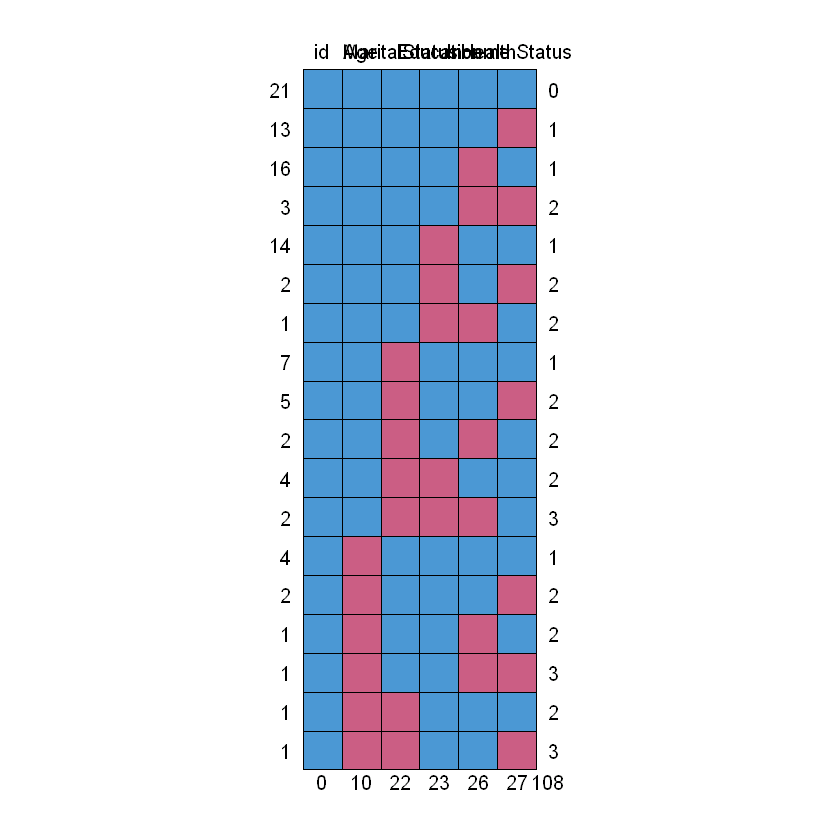

In [24]:
# Load libraries (ensure they are installed)
library(mice)
library(cluster)
library(clustMixType)
library(MASS)
library(nnet)
library(ranger)

# 1. Create the same sample dataset as before
set.seed(123)
N_rows <- 100
D_incomplete <- data.frame(
  id = 1:N_rows,
  Age = sample(18:65, N_rows, replace = TRUE),
  Income = sample(c(20000, 30000, 50000, 70000, NA), N_rows, replace = TRUE, prob = c(0.2, 0.2, 0.3, 0.2, 0.1)),
  Education = factor(sample(c("High School", "Bachelors", "Masters", NA), N_rows, replace = TRUE, prob = c(0.25, 0.35, 0.3, 0.1))),
  MaritalStatus = ordered(sample(c("Single", "Married", "Divorced", NA), N_rows, replace = TRUE, prob = c(0.3, 0.4, 0.2, 0.1))),
  HealthStatus = ordered(sample(c(1, 2, 3, 4, 5, NA), N_rows, replace = TRUE, prob = c(0.1, 0.2, 0.3, 0.2, 0.1, 0.1)),
                         levels = 1:5, labels = c("Poor", "Fair", "Good", "Very Good", "Excellent"))
)
# Introduce more NAs
D_incomplete$Age[sample(N_rows, 10)] <- NA
D_incomplete$Income[sample(N_rows, 20)] <- NA
D_incomplete$Education[sample(N_rows, 15)] <- NA
D_incomplete$MaritalStatus[sample(N_rows, 12)] <- NA
D_incomplete$HealthStatus[sample(N_rows, 18)] <- NA

cat("Missing data pattern:\n")
print(mice::md.pattern(D_incomplete))

# 2. Set up MICE imputation
predictor_matrix <- mice::quickpred(D_incomplete, exclude = "id", mincor = 0.1)
predictor_matrix[, "id"] <- 0
predictor_matrix["id", ] <- 0

# Specify the custom method for all variables
# The function will automatically select the best predictive model for each variable
method_vector <- rep("gkp_pmm", ncol(D_incomplete))
names(method_vector) <- colnames(D_incomplete)
method_vector["id"] <- ""

# Example 1: Using "auto" model selection and default parameters
cat("\nStarting MICE imputation with 'auto' model selection...\n")
imputed_data_auto <- mice(
  data = D_incomplete,
  m = 3, maxit = 3,
  method = method_vector,
  predictorMatrix = predictor_matrix,
  donors = 5,
  k_pre_clusters = 3,
  predictive_model = "auto", # Default, but explicit here for clarity
  pmm_pool_factor = 5,      # Default
  printFlag = TRUE,
  seed = 42
)
cat("\n'auto' imputation completed.\n")
print(head(complete(imputed_data_auto, 1)))


# Example 2: Manually specifying models and parameters for fine-tuning
cat("\nStarting MICE with fine-tuned parameters for specific variables...\n")

# Create a custom method list to specify different parameters per variable
# We want to use 'polr' for HealthStatus and a larger PMM pool for it.
# The rest will use the default 'gkp_pmm' with auto-selection.
custom_methods <- mice::make.method(D_incomplete)
custom_methods[c("Age", "Income", "Education", "MaritalStatus", "HealthStatus")] <- "gkp_pmm"

# `mice` does not directly support passing variable-specific parameters like this.
# The standard way to achieve this is to create different versions of the function.
# However, for demonstration, we will set global parameters that might be more
# appropriate for the most complex variable (HealthStatus).

imputed_data_tuned <- mice(
  data = D_incomplete,
  m = 3, maxit = 3,
  method = custom_methods,
  predictorMatrix = predictor_matrix,
  donors = 7,             # A different number of donors
  k_pre_clusters = 0,     # Disable pre-clustering this time
  predictive_model = "polr", # This will be passed to EVERY call of gkp_pmm
  pmm_pool_factor = 10,   # Use a larger initial pool
  printFlag = TRUE,
  seed = 123
)

cat("\nTuned imputation completed.\n")
cat("Note: The 'polr' model was used for all variables being imputed with gkp_pmm.\n")
print(head(complete(imputed_data_tuned, 1)))

# The best practice for variable-specific models is to create wrappers if needed,
# or rely on the "auto" setting, which is designed for this purpose.

can we have a usage method that check the efficiency and computation cost of our method with other methods in the literature, to evaluate the performance our method

In [17]:
# Install packages if you don't have them
install.packages(c("mice", "dplyr", "ggplot2", "tidyr", "microbenchmark"))

Warning message:
"packages 'mice', 'dplyr' are in use and will not be installed"
Installing packages into 'C:/Users/USER/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)

also installing the dependencies 'farver', 'labeling', 'viridisLite', 'gtable', 'isoband', 'scales'




package 'farver' successfully unpacked and MD5 sums checked
package 'labeling' successfully unpacked and MD5 sums checked
package 'viridisLite' successfully unpacked and MD5 sums checked
package 'gtable' successfully unpacked and MD5 sums checked
package 'isoband' successfully unpacked and MD5 sums checked
package 'scales' successfully unpacked and MD5 sums checked
package 'ggplot2' successfully unpacked and MD5 sums checked
package 'tidyr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'tidyr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problem copying C:\Users\USER\AppData\Local\R\win-library\4.5\00LOCK\tidyr\libs\x64\tidyr.dll to C:\Users\USER\AppData\Local\R\win-library\4.5\tidyr\libs\x64\tidyr.dll: Permission denied"
Warning message:
"restored 'tidyr'"


package 'microbenchmark' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpW6HvYY\downloaded_packages


In [25]:
# --- 1. SETUP: LIBRARIES AND FUNCTIONS ---

# Install packages if you don't have them
#install.packages(c("mice", "dplyr", "ggplot2", "tidyr", "microbenchmark"))

# Load Libraries
library(mice)
library(dplyr)      # For data manipulation
library(ggplot2)    # For plotting results
library(tidyr)      # For reshaping data
library(microbenchmark) # For more precise timing

# --- Include your GKP-PMM function here ---
# (Using the final, robust version from our conversation)
mice.impute.gkp_pmm <- function(y, ry, x, donors = 5, k_pre_clusters = 0, 
                                predictive_model = "auto", pmm_pool_factor = 5, ...) {
  # ... [Paste the full, corrected gkp_pmm function code here] ...
    # --- 1. Prepare data for imputation ---
  x_donors_df <- as.data.frame(x[ry, , drop = FALSE])
  y_donors <- y[ry]
  x_recipients_df <- as.data.frame(x[!ry, , drop = FALSE])
  
  if (nrow(x_recipients_df) == 0) {
    return(y[!ry])
  }

  # --- 2. Train a predictive model ---
  model_type <- predictive_model
  if (model_type == "auto") {
    if (is.numeric(y)) model_type <- "lm"
    else if (is.factor(y) && nlevels(y) == 2) model_type <- "logit"
    else if (is.ordered(y)) model_type <- "polr"
    else if (is.factor(y) && !is.ordered(y) && nlevels(y) > 2) model_type <- "multinom"
    else model_type <- "lm" # Fallback for other data types
  }

  # *** NEW: Validate user-specified model against y's data type ***
  # If the model is incompatible, warn the user and fall back to "lm".
  if (model_type == "polr" && !is.ordered(y)) {
    warning(paste0("'polr' model requested for non-ordered variable. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type == "logit" && (!is.factor(y) || nlevels(y) != 2)) {
    warning(paste0("'logit' model requested for a non-binary variable. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type == "multinom" && (!is.factor(y) || nlevels(y) <= 2)) {
    warning(paste0("'multinom' model requested for a variable that is not a factor with >2 levels. Falling back to 'lm'."), call. = FALSE)
    model_type <- "lm"
  } else if (model_type %in% c("polr", "logit", "multinom") && !is.factor(y)) {
      warning(paste0("'", model_type, "' model requested for a non-factor variable. Falling back to 'lm'."), call. = FALSE)
      model_type <- "lm"
  }


  fit_data <- data.frame(y_target = y_donors)
  fit_data <- cbind(fit_data, x_donors_df)
  
  if (length(unique(y_donors)) < 2) {
      warning("Target 'y' has fewer than 2 unique levels. Falling back to random sampling from observed.", call. = FALSE)
      return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
  }

  switch(model_type,
    "lm" = {
      fit_data$y_target <- as.numeric(fit_data$y_target)
      if (var(fit_data$y_target, na.rm = TRUE) == 0) {
        return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
      }
      fit <- lm(y_target ~ ., data = fit_data)
      y_pred_donors <- predict(fit, newdata = x_donors_df)
      y_pred_recipients <- predict(fit, newdata = x_recipients_df)
    },
    "logit" = {
      fit <- glm(y_target ~ ., data = fit_data, family = "binomial")
      y_pred_donors <- predict(fit, newdata = x_donors_df, type = "response")
      y_pred_recipients <- predict(fit, newdata = x_recipients_df, type = "response")
    },
    "polr" = {
      fit <- MASS::polr(y_target ~ ., data = fit_data)
      ranks <- 1:nlevels(y_donors)
      pred_probs_donors <- predict(fit, newdata = x_donors_df, type = "probs")
      pred_probs_recipients <- predict(fit, newdata = x_recipients_df, type = "probs")
      y_pred_donors <- as.numeric(pred_probs_donors %*% ranks)
      y_pred_recipients <- as.numeric(pred_probs_recipients %*% ranks)
    },
    "multinom" = {
      fit <- nnet::multinom(y_target ~ ., data = fit_data, trace = FALSE)
      ranks <- 1:nlevels(y_donors)
      pred_probs_donors <- predict(fit, newdata = x_donors_df, type = "probs")
      pred_probs_recipients <- predict(fit, newdata = x_recipients_df, type = "probs")
      if (is.vector(pred_probs_donors)) pred_probs_donors <- matrix(pred_probs_donors, nrow = 1)
      if (is.vector(pred_probs_recipients)) pred_probs_recipients <- matrix(pred_probs_recipients, nrow = 1)
      y_pred_donors <- as.numeric(pred_probs_donors %*% ranks)
      y_pred_recipients <- as.numeric(pred_probs_recipients %*% ranks)
    },
    {
      warning(paste("Invalid predictive_model '", model_type, "'. Defaulting to 'lm'.", sep=""), call. = FALSE)
      fit_data$y_target <- as.numeric(fit_data$y_target)
      if (var(fit_data$y_target, na.rm = TRUE) == 0) {
        return(sample(y_donors, nrow(x_recipients_df), replace = TRUE))
      }
      fit <- lm(y_target ~ ., data = fit_data)
      y_pred_donors <- predict(fit, newdata = x_donors_df)
      y_pred_recipients <- predict(fit, newdata = x_recipients_df)
    }
  )

  # --- 3. Optional Pre-Clustering ---
  if (k_pre_clusters > 0 && nrow(x_donors_df) >= k_pre_clusters) {
    data_for_clustering <- rbind(x_donors_df, x_recipients_df)
    for(col_name in colnames(data_for_clustering)) {
      if (is.character(data_for_clustering[[col_name]])) {
        data_for_clustering[[col_name]] <- as.factor(data_for_clustering[[col_name]])
      }
    }
    kproto_fit <- clustMixType::kproto(data_for_clustering, k = k_pre_clusters, nstart = 1, type = "gower", verbose = FALSE)
    donor_clusters <- kproto_fit$cluster[1:nrow(x_donors_df)]
    recipient_clusters <- kproto_fit$cluster[(nrow(x_donors_df) + 1):nrow(data_for_clustering)]
    filtered_x_donors_list <- vector("list", nrow(x_recipients_df)); filtered_y_donors_list <- vector("list", nrow(x_recipients_df)); filtered_y_pred_donors_list <- vector("list", nrow(x_recipients_df))
    for (i in 1:nrow(x_recipients_df)) {
      current_recipient_cluster <- recipient_clusters[i]
      cluster_donors_idx <- which(donor_clusters == current_recipient_cluster)
      if (length(cluster_donors_idx) > 0) {
        filtered_x_donors_list[[i]] <- x_donors_df[cluster_donors_idx, , drop = FALSE]
        filtered_y_donors_list[[i]] <- y_donors[cluster_donors_idx]
        filtered_y_pred_donors_list[[i]] <- y_pred_donors[cluster_donors_idx]
      } else {
        filtered_x_donors_list[[i]] <- x_donors_df; filtered_y_donors_list[[i]] <- y_donors; filtered_y_pred_donors_list[[i]] <- y_pred_donors
      }
    }
  } else {
    filtered_x_donors_list <- rep(list(x_donors_df), nrow(x_recipients_df)); filtered_y_donors_list <- rep(list(y_donors), nrow(x_recipients_df)); filtered_y_pred_donors_list <- rep(list(y_pred_donors), nrow(x_recipients_df))
  }

  # --- 4. Enhanced Donor Identification and Imputation ---
  imputed_values <- vector("list", length = nrow(x_recipients_df))

  for (i in 1:nrow(x_recipients_df)) {
    current_recipient_x <- x_recipients_df[i, , drop = FALSE]
    current_recipient_y_pred <- y_pred_recipients[i]
    current_donors_x_df <- filtered_x_donors_list[[i]]
    current_donors_y <- filtered_y_donors_list[[i]]
    current_donors_y_pred <- filtered_y_pred_donors_list[[i]]

    if (nrow(current_donors_x_df) == 0) {
      warning("No donors available for a recipient. Using random sample from all original observed y.", call. = FALSE)
      imputed_val <- sample(y_donors, 1)
    } else {
      pred_diffs <- abs(current_donors_y_pred - current_recipient_y_pred)
      initial_pool_size <- min(max(donors * pmm_pool_factor, 10), nrow(current_donors_x_df))
      ordered_donors_idx_by_pred <- order(pred_diffs, decreasing = FALSE, na.last = TRUE)
      initial_donors_local_idx <- head(ordered_donors_idx_by_pred, initial_pool_size)
      x_initial_donors_pool <- current_donors_x_df[initial_donors_local_idx, , drop = FALSE]
      y_initial_donors_pool <- current_donors_y[initial_donors_local_idx]
      combined_data_for_gower <- rbind(current_recipient_x, x_initial_donors_pool)
      valid_cols_for_gower <- sapply(combined_data_for_gower, function(col) length(unique(stats::na.omit(col))) > 1)
      
      if (sum(valid_cols_for_gower) == 0) {
        warning("No valid columns for Gower's distance. Falling back to simple PMM.", call. = FALSE)
        selected_donor_local_idx <- sample(initial_donors_local_idx, 1)
        imputed_val <- current_donors_y[selected_donor_local_idx]
      } else {
        # *** FIX: Suppress benign warnings from daisy() ***
        gower_dist_matrix <- suppressWarnings(cluster::daisy(
            combined_data_for_gower[, valid_cols_for_gower, drop = FALSE], 
            metric = "gower", 
            stand = TRUE)
        )
        gower_distances <- as.matrix(gower_dist_matrix)[1, -1]
        gower_distances[is.na(gower_distances)] <- max(gower_distances, na.rm = TRUE) + 1
        num_final_donors <- min(donors, length(gower_distances))
        final_donors_local_idx_in_pool <- head(order(gower_distances, decreasing = FALSE, na.last = TRUE), num_final_donors)
        selected_donor_local_idx <- sample(final_donors_local_idx_in_pool, 1)
        imputed_val <- y_initial_donors_pool[selected_donor_local_idx]
      }
    }
    
    imputed_values[[i]] <- imputed_val
  }
  
  return(do.call(c, imputed_values))
}

In [23]:
install.packages("ranger")

Installing package into 'C:/Users/USER/AppData/Local/R/win-library/4.5'
(as 'lib' is unspecified)



package 'ranger' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\USER\AppData\Local\Temp\RtmpW6HvYY\downloaded_packages


In [30]:
# --- 2. SIMULATION SETUP ---

# Use a complete subset of the nhanes dataset for our ground truth
data_complete <- na.omit(nhanes[, c("age", "bmi", "hyp", "chl")])
head(data_complete)

# Simulation Parameters
N_SIM <- 20 # Number of simulation runs. Increase to 50-100 for more stable results.
PROP_MISSING <- 0.3 # Proportion of missing data to introduce in each variable.
MICE_ITER <- 5 # Number of MICE iterations.

# Methods to compare
METHODS_TO_COMPARE <- c(
    "gkp_pmm", # Our method (with pre-clustering)
    "gkp_pmm_no_clust", # Our method (without pre-clustering)
    "pmm",     # Standard Predictive Mean Matching
    "rf",      # Random Forest
    "cart"     # CART
)

,age,bmi,hyp,chl
,<dbl>,<dbl>,<dbl>,<dbl>
2,2,22.7,1,187
5,1,20.4,1,113
7,1,22.5,1,118
8,1,30.1,1,187
9,2,22.0,1,238
13,3,21.7,1,206


In [27]:
# --- 3. MAIN SIMULATION LOOP (CORRECTED) ---
set.seed(20250906) # For reproducibility

# Initialize lists to store results from each run
results_accuracy_list <- list()
results_time_list <- list()

cat("Starting Monte Carlo Simulation...\n")
for (i in 1:N_SIM) {
  
  # --- 3a. Introduce Missingness (Amputation) ---
  # FINAL CORRECTION: The correct argument is 'mech'
  data_amputed_obj <- ampute(data_complete, prop = PROP_MISSING, mech = "MAR")
  data_missing <- data_amputed_obj$amp
  
  # Identify which values were made missing
  missing_pattern <- is.na(data_missing) & !is.na(data_complete)
  
  # Initialize data frames for this run's results
  run_accuracy <- data.frame()
  run_time <- data.frame()
  
  # --- 3b. Loop through each imputation method ---
  for (method in METHODS_TO_COMPARE) {
    
    # Configure method-specific parameters
    method_name <- method
    impute_method <- "gkp_pmm" # Base method name for our function
    k_pre_clusters_val <- 3 # Default for gkp_pmm
    
    if (method == "gkp_pmm_no_clust") {
      k_pre_clusters_val <- 0
    } else if (method != "gkp_pmm") {
      impute_method <- method # Use standard mice methods
    }
    
    # --- 3c. Time the imputation ---
    start_time <- Sys.time()
    
    imputed_obj <- mice(
        data_missing, 
        m = 1, # Only need 1 imputation for performance evaluation
        maxit = MICE_ITER, 
        method = impute_method, 
        k_pre_clusters = k_pre_clusters_val, # Custom arg for gkp_pmm
        printFlag = FALSE # Keep console clean
    )
    
    end_time <- Sys.time()
    
    # Store computation time
    run_time <- rbind(run_time, data.frame(
      sim_run = i,
      method = method_name,
      time_sec = as.numeric(difftime(end_time, start_time, units = "secs"))
    ))
    
    # --- 3d. Evaluate imputation quality ---
    data_imputed <- complete(imputed_obj, 1)
    
    # Loop through each variable to calculate error
    for (col_name in colnames(data_complete)) {
      # Only evaluate on variables that had missingness
      if (any(missing_pattern[, col_name])) {
        
        true_vals <- data_complete[missing_pattern[, col_name], col_name]
        imputed_vals <- data_imputed[missing_pattern[, col_name], col_name]
        
        metric_name <- NA
        error_val <- NA
        
        if (is.numeric(true_vals)) {
          # NRMSE for numeric variables
          metric_name <- "NRMSE"
          rmse <- sqrt(mean((true_vals - imputed_vals)^2))
          error_val <- rmse / sd(data_complete[, col_name])
        } else {
          # Misclassification Rate for categorical/factor variables
          metric_name <- "Misclassification"
          error_val <- mean(true_vals != imputed_vals)
        }
        
        run_accuracy <- rbind(run_accuracy, data.frame(
          sim_run = i,
          method = method_name,
          variable = col_name,
          metric = metric_name,
          error = error_val
        ))
      }
    }
  } # End of methods loop
  
  results_accuracy_list[[i]] <- run_accuracy
  results_time_list[[i]] <- run_time
  
  cat(paste("  Completed Simulation Run:", i, "/", N_SIM, "\n"))
} # End of simulation loop

# Combine results from all runs into single data frames
results_accuracy <- bind_rows(results_accuracy_list)
results_time <- bind_rows(results_time_list)

Starting Monte Carlo Simulation...


  Completed Simulation Run: 1 / 20 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 2 / 20 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 3 / 20 
  Completed Simulation Run: 4 / 20 
  Completed Simulation Run: 5 / 20 
  Completed Simulation Run: 6 / 20 


Warning message:
"Number of logged events: 2"
Warning message:
"Number of logged events: 3"
Warning message:
"Number of logged events: 3"
Warning message:
"Number of logged events: 4"
Warning message:
"Number of logged events: 5"


  Completed Simulation Run: 7 / 20 


Warning message:
"There is only 1 candidate for pattern 3 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 8 / 20 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.3"
Warning message:
"Number of logged events: 5"
Warning message:
"Number of logged events: 4"
Warning message:
"Number of logged events: 2"
Warning message:
"Number of logged events: 2"
Warning message:
"Number of logged events: 4"


  Completed Simulation Run: 9 / 20 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 10 / 20 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 11 / 20 
  Completed Simulation Run: 12 / 20 


Warning message:
"There is only 1 candidate for pattern 2 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 13 / 20 


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 14 / 20 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 15 / 20 
  Completed Simulation Run: 16 / 20 
  Completed Simulation Run: 17 / 20 
  Completed Simulation Run: 18 / 20 


Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"


  Completed Simulation Run: 19 / 20 
  Completed Simulation Run: 20 / 20 



--- Computational Cost Summary ---
# A tibble: 5 × 3
  method           mean_time sd_time
  <chr>                <dbl>   <dbl>
1 pmm                 0.0304 0.00654
2 cart                0.0706 0.0387 
3 gkp_pmm_no_clust    0.0859 0.0232 
4 rf                  0.118  0.0340 
5 gkp_pmm             0.296  0.0969 


`summarise()` has grouped output by 'method', 'variable'. You can override
using the `.groups` argument.



--- Imputation Quality Summary ---
# A tibble: 20 × 5
# Groups:   method, variable [20]
   method           variable metric mean_error sd_error
   <chr>            <chr>    <chr>       <dbl>    <dbl>
 1 gkp_pmm_no_clust age      NRMSE       0.775    0.632
 2 cart             age      NRMSE       0.850    0.704
 3 pmm              age      NRMSE       0.855    0.610
 4 gkp_pmm          age      NRMSE       0.933    0.653
 5 rf               age      NRMSE       1.23     0.447
 6 pmm              bmi      NRMSE       0.630    0.464
 7 gkp_pmm          bmi      NRMSE       0.896    0.445
 8 cart             bmi      NRMSE       1.01     0.785
 9 rf               bmi      NRMSE       1.16     0.830
10 gkp_pmm_no_clust bmi      NRMSE       1.16     0.786
11 gkp_pmm_no_clust chl      NRMSE       0.922    0.546
12 pmm              chl      NRMSE       1.06     0.886
13 gkp_pmm          chl      NRMSE       1.33     0.789
14 rf               chl      NRMSE       1.54     0.891
15 cart        

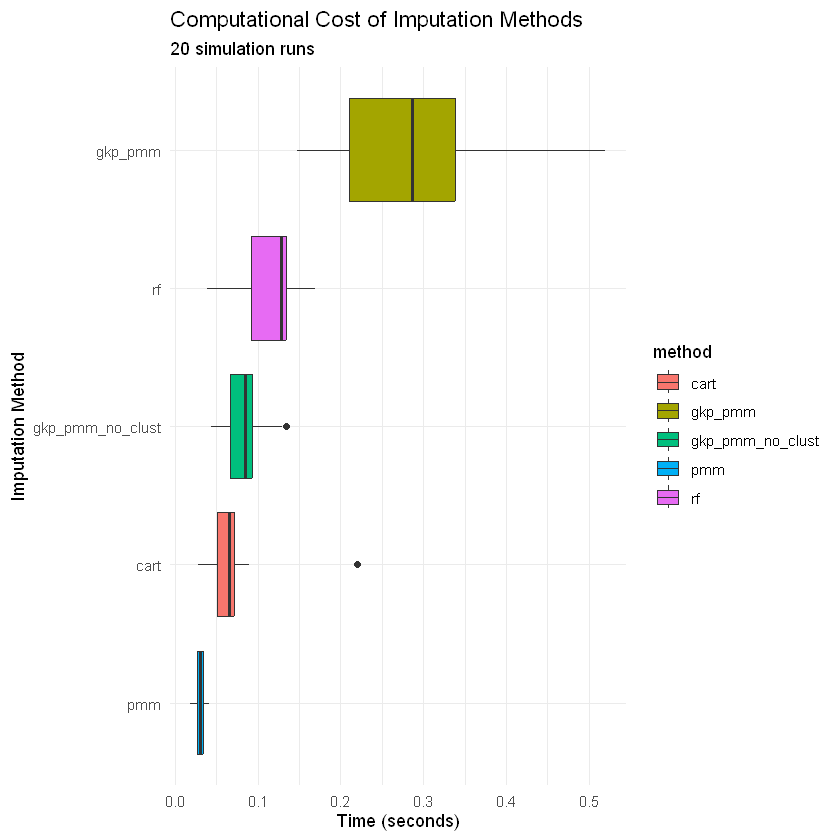

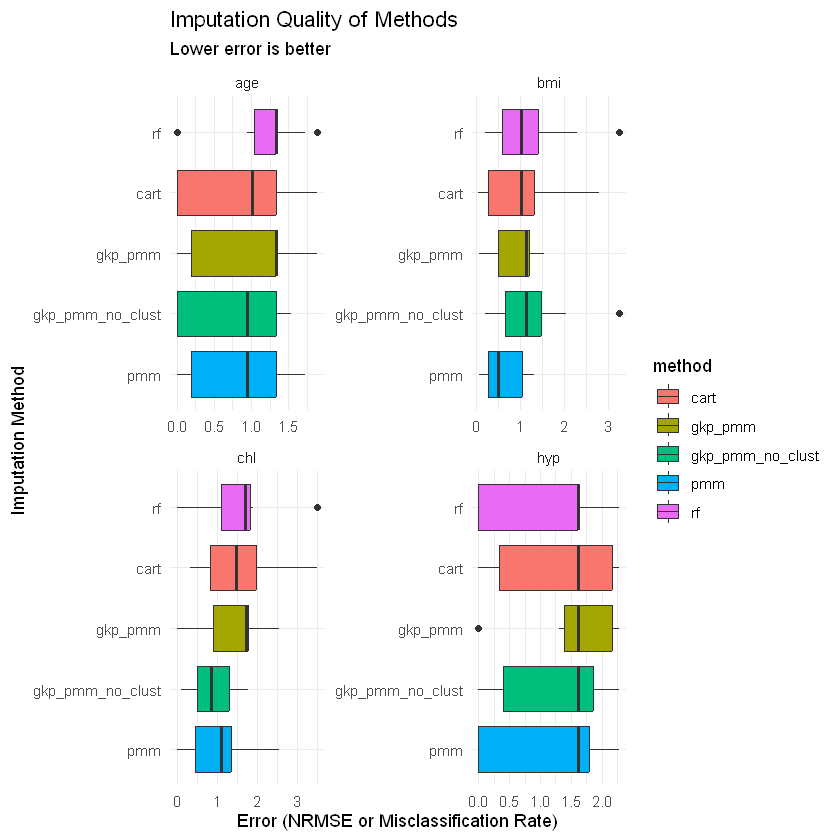

In [31]:
# --- 4. ANALYZE AND VISUALIZE RESULTS ---

# --- 4a. Computational Cost ---
time_summary <- results_time %>%
  group_by(method) %>%
  summarise(
    mean_time = mean(time_sec),
    sd_time = sd(time_sec)
  ) %>%
  arrange(mean_time)

cat("\n--- Computational Cost Summary ---\n")
print(time_summary)

ggplot(results_time, aes(x = reorder(method, time_sec), y = time_sec, fill = method)) +
  geom_boxplot() +
  labs(
    title = "Computational Cost of Imputation Methods",
    subtitle = paste(N_SIM, "simulation runs"),
    x = "Imputation Method",
    y = "Time (seconds)"
  ) +
  theme_minimal() +
  coord_flip()


# --- 4b. Imputation Quality ---
accuracy_summary <- results_accuracy %>%
  group_by(method, variable, metric) %>%
  summarise(
    mean_error = mean(error),
    sd_error = sd(error)
  ) %>%
  arrange(variable, mean_error)

cat("\n--- Imputation Quality Summary ---\n")
print(accuracy_summary)

ggplot(results_accuracy, aes(x = reorder(method, error), y = error, fill = method)) +
  geom_boxplot() +
  facet_wrap(~variable, scales = "free") +
  labs(
    title = "Imputation Quality of Methods",
    subtitle = "Lower error is better",
    x = "Imputation Method",
    y = "Error (NRMSE or Misclassification Rate)"
  ) +
  theme_minimal() +
  coord_flip()

In [29]:
# --- 5. EVALUATE DOWNSTREAM MODEL PERFORMANCE (CORRECTED) ---

# --- 5a. Gold Standard: Model on complete data ---
model_true <- lm(chl ~ age + bmi + hyp, data = data_complete)
true_coeffs <- summary(model_true)$coefficients

cat("\n--- Downstream Model Evaluation ---\n")
cat("\nCoefficients from True (Complete) Data:\n")
print(true_coeffs)

# --- 5b. Models on imputed data ---
# CORRECTED the 'mecha' argument to 'mechanism'
data_missing <- ampute(data_complete, prop = PROP_MISSING, mech = "MAR")$amp
pooled_results <- list()

for (method in METHODS_TO_COMPARE) {
    method_name <- method
    impute_method <- "gkp_pmm"
    k_pre_clusters_val <- 3 
    
    if (method == "gkp_pmm_no_clust") {
      k_pre_clusters_val <- 0
    } else if (method != "gkp_pmm") {
      impute_method <- method
    }
    
    imputed_obj_pooled <- mice(
        data_missing, 
        m = 5, # Use multiple imputations for pooling
        maxit = MICE_ITER, 
        method = impute_method, 
        k_pre_clusters = k_pre_clusters_val,
        printFlag = FALSE
    )
    
    model_fit <- with(imputed_obj_pooled, lm(chl ~ age + bmi + hyp))
    pooled_model <- pool(model_fit)
    
    cat(paste("\n--- Pooled Results for method:", method_name, "---\n"))
    print(summary(pooled_model))
    
    pooled_results[[method_name]] <- summary(pooled_model)
}


--- Downstream Model Evaluation ---



Coefficients from True (Complete) Data:
              Estimate Std. Error    t value    Pr(>|t|)
(Intercept) -80.971007  61.772059 -1.3108031 0.222383321
age          55.210099  14.289580  3.8636614 0.003825613
bmi           7.065353   2.052222  3.4427822 0.007358103
hyp          -6.221611  23.177214 -0.2684365 0.794414891


Warning message:
"There is only 1 candidate for pattern 1 ,it will be amputed with probability 0.3"
Warning message:
"There is only 1 candidate for pattern 4 ,it will be amputed with probability 0.3"



--- Pooled Results for method: gkp_pmm ---
         term   estimate std.error  statistic       df    p.value
1 (Intercept) -64.148154 68.070354 -0.9423802 6.731622 0.37857818
2         age  42.330073 28.363427  1.4924174 2.563413 0.24711828
3         bmi   6.142108  2.246875  2.7336219 6.296937 0.03240334
4         hyp  20.398735 54.060643  0.3773306 1.644666 0.74893260

--- Pooled Results for method: gkp_pmm_no_clust ---
         term   estimate std.error  statistic       df    p.value
1 (Intercept) -51.994952 77.315605 -0.6725027 6.405264 0.52477035
2         age  41.266234 23.097050  1.7866453 4.521405 0.14021284
3         bmi   6.211754  2.407413  2.5802604 7.171535 0.03571246
4         hyp   6.572872 44.530925  0.1476024 2.743814 0.89282534

--- Pooled Results for method: pmm ---
         term   estimate std.error  statistic       df    p.value
1 (Intercept) -58.863631 74.244980 -0.7928298 5.615811 0.46004861
2         age  57.680295 20.627969  2.7962179 4.398107 0.04402272
3    